<a href="https://colab.research.google.com/github/Ab2207/Academic-Projects-Data-Analytics/blob/main/Masters%20Thesis%20Experiment%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np 
import string 
string.punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
import re
import unicodedata
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Activation
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/Airline_Tweets.csv")

In [ ]:
def tweets_cleaning(text):
    lowercase = text.lower()
    punc_removal = [char for char in lowercase if char not in string.punctuation]
    punc_removal_joined = ''.join(punc_removal)
    url_removal = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', punc_removal_joined, flags=re.MULTILINE)
    emoji_removal = url_removal.encode('ascii', 'ignore').decode('ascii')
    stopwords_removal = [word for word in emoji_removal.split() if word not in stopwords.words('english')]
    return stopwords_removal

In [ ]:
data['cleaned_text'] = data['text'].apply(tweets_cleaning).astype(str)

In [ ]:
train_conditionList = [
                 data['airline_sentiment'] == 'negative',
                 data['airline_sentiment'] == 'positive',
                 data['airline_sentiment'] == 'neutral'
                 ]
train_choiceList = ['-1', '1' ,'0']
data['target'] = np.select(train_conditionList, train_choiceList, default='no_label')

In [ ]:
max_fatures = 16561
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['cleaned_text'].values)
X = tokenizer.texts_to_sequences(data['cleaned_text'].values)
X = pad_sequences(X, maxlen=26, padding='post')

In [ ]:
embeddings_index = dict()
f = open('/content/gdrive/My Drive/glove.twitter.27B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [ ]:
embedding_matrix = np.zeros((max_fatures, 200))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
embed_dim = 200
lstm_out = 128

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1], weights=[embedding_matrix],trainable=False))
model.add(LSTM(lstm_out, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(lstm_out))
model.add(Dropout(0.3))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 200)           3312200   
_________________________________________________________________
lstm (LSTM)                  (None, 26, 128)           168448    
_________________________________________________________________
dropout (Dropout)            (None, 26, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
_________________________________________________________________
activation (Activation)      (None, 3)                 0

In [ ]:
Y = pd.get_dummies(data['target']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 1234)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11712, 26) (11712, 3)
(2928, 26) (2928, 3)


In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 14, verbose = 1, validation_data=(X_test, Y_test), batch_size=batch_size)

Epoch 1/14
366/366 [==============================] - 23s 62ms/step - loss: 0.9273 - accuracy: 0.6259 - val_loss: 0.9121 - val_accuracy: 0.6308
Epoch 2/14
366/366 [==============================] - 22s 60ms/step - loss: 0.9203 - accuracy: 0.6259 - val_loss: 0.9121 - val_accuracy: 0.6308
Epoch 3/14
366/366 [==============================] - 22s 60ms/step - loss: 0.9196 - accuracy: 0.6259 - val_loss: 0.9140 - val_accuracy: 0.6308
Epoch 4/14
366/366 [==============================] - 22s 59ms/step - loss: 0.9192 - accuracy: 0.6259 - val_loss: 0.9122 - val_accuracy: 0.6308
Epoch 5/14
366/366 [==============================] - 22s 60ms/step - loss: 0.9189 - accuracy: 0.6259 - val_loss: 0.9123 - val_accuracy: 0.6308
Epoch 6/14
366/366 [==============================] - 22s 60ms/step - loss: 0.9198 - accuracy: 0.6259 - val_loss: 0.9130 - val_accuracy: 0.6308
Epoch 7/14
366/366 [==============================] - 22s 59ms/step - loss: 0.9192 - accuracy: 0.6259 - val_loss: 0.9122 - val_accuracy:

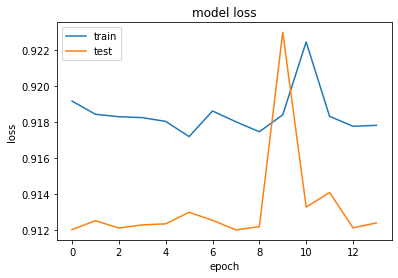

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()